### A/B Testing for Marketing

A/B testing is a vital method in marketing that enables businesses to compare two versions of a campaign to determine which one performs better. Key components of A/B testing include determining key metrics, which involves identifying the metrics that will measure success, such as conversion rates or engagement levels. Test allocation is also crucial, as traffic should be strategically allocated between the control and variant groups to ensure reliable results.

Comparing conversion rates allows for the analysis of performance differences between the two groups. Additionally, calculating lift and conducting significance testing are necessary to determine if observed differences are statistically significant. Creating a lift function can automate the calculation of lift for various tests, enhancing efficiency.

Evaluating statistical significance is important to confirm that results are not due to random chance. A/B testing can also be enhanced through segmentation, which allows for tailored tests that cater to different demographics or behaviors, thereby increasing relevance. Building an A/B test segmenting function is essential for efficiently segmenting users for targeted testing. Finally, using the segmentation function in A/B tests can optimize marketing strategies based on audience insights.

The notebook below demonstrates these concepts in practice, providing a comprehensive overview of how to effectively implement A/B testing in marketing strategies.

<h1>Import packages</h1>


In [150]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import matplotlib as mpl
from cycler import cycler

import numpy as np
import os as os
import time
import pprint
import sys
import re
import json
import itertools
import datetime as dt
import scipy.stats as stats
import scipy


import pandas_datareader.data as web

# security
from dotenv import load_dotenv

<h1>Import data</h1>

In [151]:
ab_test = pd.read_csv('data/marketing_data_cleaned.csv', index_col=0)

print(ab_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10037 entries, 0 to 10036
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  10037 non-null  object 
 1   date_served              10037 non-null  object 
 2   marketing_channel        10037 non-null  object 
 3   variant                  10037 non-null  object 
 4   converted                10037 non-null  bool   
 5   language_displayed       10037 non-null  object 
 6   language_preferred       10037 non-null  object 
 7   age_group                10037 non-null  object 
 8   subscribing_channel      1856 non-null   object 
 9   is_retained              10037 non-null  bool   
 10  HouseAds                 10037 non-null  bool   
 11  marketing_channel_coded  10037 non-null  int64  
 12  channel_code             1856 non-null   float64
 13  is_correct_lang          10037 non-null  object 
dtypes: bool(3), float64(1), int

<h2> Data preparation for the A/B-analyis</h2>

In [152]:
marketing_channel_counts = \
ab_test['marketing_channel'].value_counts()
marketing_channel_counts.index

Index(['House Ads', 'Instagram', 'Facebook', 'Push', 'Email'], dtype='object', name='marketing_channel')

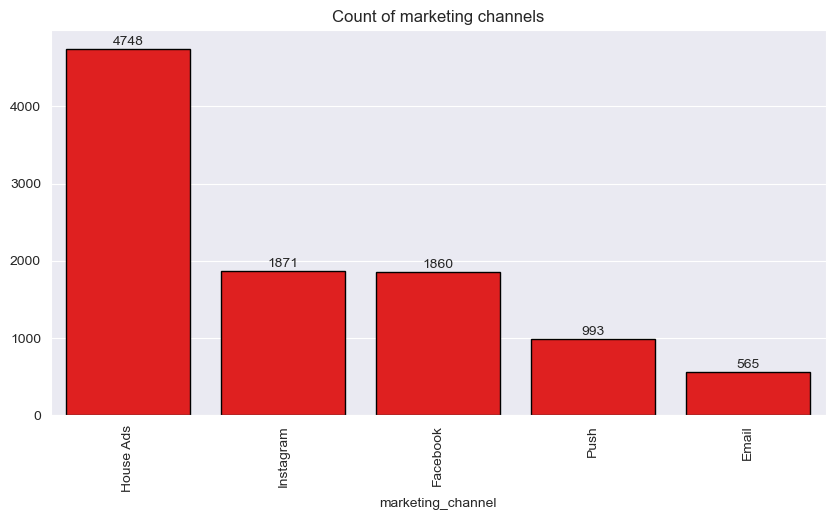

In [153]:
sns.set_style('darkgrid')

plt.figure(figsize=(10,5))

ax = sns.barplot(x=marketing_channel_counts.index,  # Assuming channel names are in the first column
                 y=marketing_channel_counts.values,  # Assuming counts are in the second column              
                 edgecolor='black', color = "red" )

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.xticks(rotation=90)
plt.title("Count of marketing channels")
plt.show()

In [154]:
# Isolating the rows of marketing where the 'marketing_channel' is 'Email' and storing the results in email_rows.
email_rows = ab_test[ab_test['marketing_channel'] == 'Email']

email_rows.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,subscribing_channel,is_retained,HouseAds,marketing_channel_coded,channel_code,is_correct_lang
354,a100000526,2018-01-01,Email,personalization,True,Arabic,Arabic,0-18 years,Email,True,False,5,4.0,Yes
358,a100000530,2018-01-05,Email,personalization,True,Arabic,Arabic,19-24 years,Email,True,False,5,4.0,Yes
362,a100000534,2018-01-09,Email,personalization,False,English,English,45-55 years,Email,True,False,5,4.0,Yes
366,a100000538,2018-01-13,Email,personalization,True,Arabic,Arabic,24-30 years,Email,False,False,5,4.0,Yes
370,a100000542,2018-01-17,Email,personalization,True,English,English,0-18 years,Email,False,False,5,4.0,Yes


In [155]:
# There are two different groups.
# In the control are no changes, but in perso are.
# Is there a significant difference in subscriptions in the perso variant?
print(ab_test['variant'].value_counts())

variant
control            5091
personalization    4946
Name: count, dtype: int64


In [156]:
# Grouping email by variant and sum the unique users and store the results in alloc.

unique_users_in_group = \
email_rows.groupby('variant')['user_id'].nunique()

unique_users_in_group 

variant
control            270
personalization    284
Name: user_id, dtype: int64

270
284


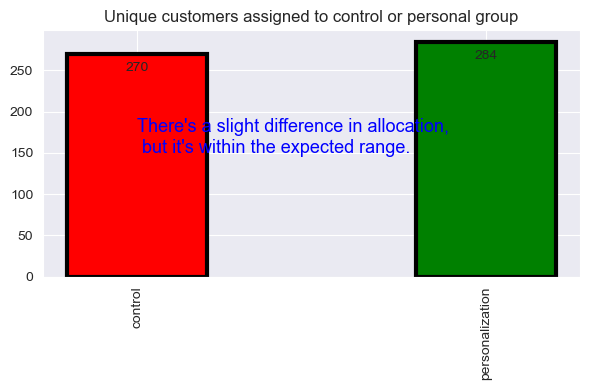

In [157]:
fig, ax = plt.subplots(figsize=(6, 4))

bars = ax.bar(unique_users_in_group.index, unique_users_in_group.values, 
              width=0.4, color=['red', 'green'], edgecolor='black', linewidth=3)
ax.set_title('Unique customers assigned to control or personal group', size=12)

for bar in bars:
    height = bar.get_height()
    print(height)
    if height > 0: 
        ax.annotate(f'{height:.0f}',
                   (bar.get_x() + bar.get_width() / 2., height),
                   ha='center', va='center',
                   xytext=(0, -10),
                   textcoords='offset points')
    
# matplotlib.pyplot.text(x, y, s, fontdict=None, **kwargs)

plt.text(0, 150, "There's a slight difference in allocation, \n but it's within the expected range.",
        size=13, color='blue')

plt.xticks(rotation=90)

plt.tight_layout()  # Prevent title overlap
plt.show()





<h4>Definition of Conversion Rate in Advertising</h4>

<p>
A conversion rate is a critical marketing metric that measures the percentage of potential customers who take a specific desired action after engaging with an advertisement or marketing campaign. This action could range from making a purchase, signing up for a newsletter, downloading an app, filling out a contact form, or completing any other predefined goal that represents value for a business.
Usage of Conversion Rate
</p>
<p>
Marketers and advertisers use conversion rates as a key performance indicator to evaluate the effectiveness of their advertising strategies. By tracking conversion rates, businesses can understand how well their marketing efforts are performing in transforming potential leads into actual customers. The calculation is straightforward: divide the number of conversions by the total number of visitors or interactions, then multiply by 100 to get a percentage. For example, if 50 people out of 1,000 website visitors make a purchase, the conversion rate would be 5%.
<p>

https://www.creatopy.com/blog/what-is-conversion-rate-in-advertising/
 

<h4>Conversion rate for the control and personalization group</h4>
    
<p>
The goal here is to get the two conversion rates or means.<br>
This is the basis for calculating the Lift and determine the statistical significance.
However, before a preparation of the data is necessary to ensure, it's validity.
In particular it is necessary to ensure that each user is represented only once per variant (even if they interacted multiple times), and to transform this many-to-many relationship into a one-to-many relationship. This is achieved by grouping user_id and variant and reduce it to a single conversion status per user per variant.
</p>

In [158]:
email_rows['converted'].unique()
email_rows['converted'].value_counts()

converted
False    372
True     193
Name: count, dtype: int64

In [159]:
email_rows['variant'].value_counts()

variant
personalization    291
control            274
Name: count, dtype: int64

In [160]:
# Is the conversion deviating between perso and control?
# Conversion higher or lower or the same?

email_rows.groupby('variant')['converted'].count()

variant
control            274
personalization    291
Name: converted, dtype: int64

<h4> Is the user-id occuring multiple time in different rows</h4>
Are user_id's occurring multiple times?

Yes, for example one user can be in multiple marketing channels at different points in time.<br>

In [161]:
print(len(ab_test['user_id'].unique()))
print(ab_test.shape[0])
print(10037 - 7309)
# User-id's occur 2728 times more often than unique user id's are there.

7309
10037
2728


In [162]:
duplicates = ab_test[ab_test['user_id'].duplicated(keep=False)]
print(duplicates[['user_id', 'marketing_channel', 'variant', 'date_served', 'converted']])

         user_id marketing_channel          variant date_served  converted
21    a100000050         House Ads  personalization  2018-01-02       True
22    a100000050         House Ads  personalization  2018-01-01      False
23    a100000051         House Ads  personalization  2018-01-02       True
24    a100000051              Push  personalization  2018-01-01      False
25    a100000052         House Ads  personalization  2018-01-02       True
...          ...               ...              ...         ...        ...
9532  a100006807         Instagram  personalization  2018-01-31      False
9533  a100006808          Facebook  personalization  2018-01-05      False
9534  a100006808              Push  personalization  2018-01-31      False
9535  a100006809         House Ads  personalization  2018-01-05      False
9536  a100006809         Instagram  personalization  2018-01-31      False

[5009 rows x 5 columns]


The purpose of the code is specifically to handle cases where a user_id appears multiple times in the data. This is particularly useful because it simplifies the data by consolidating multiple rows per user_id and variant into a single value.

In [163]:
subscribers = email_rows.groupby(['user_id', 'variant'])['converted'].max()
print(subscribers.head())
print('-----------------------------------------')
print(subscribers.tail())
print('-----------------------------------------')
print(subscribers.isnull().sum())
print(subscribers.shape)

user_id     variant        
a100000526  personalization     True
a100000530  personalization     True
a100000534  personalization    False
a100000538  personalization     True
a100000542  personalization     True
Name: converted, dtype: bool
-----------------------------------------
user_id     variant
a100007288  control    True
a100007289  control    True
a100007290  control    True
a100007291  control    True
a100007293  control    True
Name: converted, dtype: bool
-----------------------------------------
0
(554,)


In [164]:
subscribers_df = pd.DataFrame(subscribers.unstack(level=1))
print(subscribers_df.head())
print('-----------------------------------------')
print(subscribers_df.tail())
print('-----------------------------------------')
print(print(subscribers_df.isnull().sum()))
283 + 269

variant    control personalization
user_id                           
a100000526     NaN            True
a100000530     NaN            True
a100000534     NaN           False
a100000538     NaN            True
a100000542     NaN            True
-----------------------------------------
variant    control personalization
user_id                           
a100007288    True             NaN
a100007289    True             NaN
a100007290    True             NaN
a100007291    True             NaN
a100007293    True             NaN
-----------------------------------------
variant
control            283
personalization    269
dtype: int64
None


552

In [165]:
# building the groups needed for comparison 
# is there a significant difference in the mean of the groups
# inferential statistic or a/b testing
control = subscribers_df['control'].dropna()
perso = subscribers_df['personalization'].dropna()

print(type(control))
print('-----------------------------------------')
print(control.head())
print('-----------------------------------------')
print(control.info())

<class 'pandas.core.series.Series'>
-----------------------------------------
user_id
a100000687    False
a100000688     True
a100000689     True
a100000690     True
a100000691     True
Name: control, dtype: object
-----------------------------------------
<class 'pandas.core.series.Series'>
Index: 270 entries, a100000687 to a100007293
Series name: control
Non-Null Count  Dtype 
--------------  ----- 
270 non-null    object
dtypes: object(1)
memory usage: 4.2+ KB
None


<p>
The conversion rates are the means of the control and perso group.<br>
Is the difference significant?
</p>

In [166]:
# conversion Rate= Number of conversions / Total number of users exposed to the variant 
control_conversion_rate = np.round(np.mean(control), 2)
perso_conversion_rate = np.round(np.mean(perso), 2)

print(f'Conversion rate of the control group: {control_conversion_rate}')
print(f'Conversion rate of the perso group: {perso_conversion_rate}')

Conversion rate of the control group: 0.28
Conversion rate of the perso group: 0.39


<b>Conclusion</b>:
<p>
The conversion rate of the of the perso group is higher than that of the control group.<br>
This indicates an effectiveness of the email variant treatment.
</p>

<h4>Lift</h4>

<p>
In A/B testing, lift refers to the percentage or relative improvement in a key metric (such as conversion rate, click-through rate, or revenue) achieved by the treatment group (B) compared to the control group (A). It quantifies the effectiveness of the changes introduced in the treatment group.
</p>

<p>
Lift = (Conversion RateTreatment − Conversion RateControl) / Conversion RateControl ×100
</p>

In [167]:
def lift(c, p):
    control_mean = np.mean(c)
    perso_mean = np.mean(p)
    lift = np.round((perso_mean - control_mean) / control_mean *100, 2)
    return str(lift) + "%"

In [168]:
print(f"Lift: {lift(control, perso)}")
# The improvement in conversion is with 39% of 100 large.

Lift: 38.85%


<p>
The next step is to test for the statistical significance with a T-Test.
</p>

<h4>What is a T test?</h4>

<p>
A t-test (also called Student’s t-test) is a statistical method used to assess the difference between the means of exactly two groups. It concentrates on a single numerical variable, rather than focusing on counts or relationships among multiple variables. When analyzing the average of a sample of measurements, t-tests are the most frequently used technique for data evaluation.
</p>

https://www.statisticshowto.com/probability-and-statistics/t-distribution/independent-samples-t-test/

<p>
The significance level is set at 0.05.<br>
Null-hypothesis: there is no difference in means.
</p>

In [169]:
control = control.astype(int)
perso = perso.astype(int)

In [170]:
import statistics
stats.ttest_ind(control, perso, equal_var=False)

TtestResult(statistic=-2.739963028212209, pvalue=0.006343622269724659, df=551.4774029266305)

<p>
It is highly unlikely to observe a p-value such small if the Null would be true.<br>
There is a statistical difference of the means.
</p>


<h3> A/B testing for customer segments</h3>

<p>
When running A/B experiments, it is important to check how new features are affecting specific demographics. Sometimes features that are highly appealing to one group are less appealing to others.

The function ab_segments() analyzes the impact of the A/B tests on segments of data and is reusable for this kind of data.
</p>

In [171]:
ab_test['language_displayed'].value_counts() 

language_displayed
English    9793
Spanish     136
German       81
Arabic       27
Name: count, dtype: int64

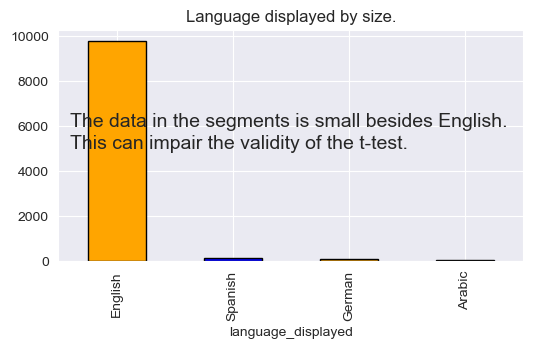

In [172]:

ab_test['language_displayed'].value_counts().plot.bar(figsize=(6,3), edgecolor='black',
                                                     color=['orange', 'blue'])
plt.text(-0.4, 6000, "The data in the segments is small besides English.", size=14)
plt.text(-0.4, 5000, "This can impair the validity of the t-test.", size=14)

plt.title('Language displayed by size.')

plt.show()

In [173]:
# Preparation

# print(ab_test.info())
# What input do I need?
# The segment and the marketing channel
# In this case the marketing channel is 'Email'

# print(ab_test['language_displayed'].unique())
# print(ab_test['variant'].unique())
# email_rows_2 = ab_test[(ab_test['marketing_channel']=='Email') & (ab_test['language_displayed']=='English')]
# print(email_rows_2)

# Consolidating user_id from many to many to one to one
# One user_id to one state of converted
# The max func selects the 'converted' users or subscribers on ground of the email
# subscribers = email_rows.groupby(['user_id', 'variant'])['converted'].max()
# Now I want to get the subscribers in the control and perso groups
# print(type(subscribers.unstack(level=1)))
# subscribers_2 = pd.DataFrame(subscribers.unstack(level=1))

# control = subscribers_2['control'].dropna()
# print(control.head())
# personalization = subscribers_2['personalization'].dropna()
# print(perso.head())
# Now there are two groups or columns to compare
# subscribers_2.head()

# print(f'lift: {lift(control, personalization)}')
# print(f'T-test: {stats.ttest_ind(control.astype(int), personalization.astype(int))}')

In [174]:
# Turning the prepared code into a function ab_segment

def ab_segment(segment):
    """ Calculating lift and t-test for a customer segment in form of a column. """
    for subsegment in np.unique(ab_test[segment].values):
        email_rows = \
        ab_test[(ab_test['marketing_channel']=='Email') & (ab_test[segment]==subsegment)]
        subscribers = email_rows.groupby(['user_id', 'variant'])['converted'].max()
        subscribers = pd.DataFrame(subscribers.unstack(level=1))
        control = pd.to_numeric(subscribers['control'].dropna())
        print(control.shape)
        personalization = pd.to_numeric(subscribers['personalization'].dropna())
        print(personalization.shape)
        print(subsegment)
        print(f'Lift: {lift(control, personalization)}')
        print(f'T-test: {stats.ttest_ind(control, personalization, equal_var=False)}', '\n\n')
        


In [175]:
ab_segment('language_displayed')

(5,)
(5,)
Arabic
Lift: 50.0%
T-test: TtestResult(statistic=-0.5773502691896255, pvalue=0.5795840000000001, df=8.0) 


(240,)
(248,)
English
Lift: 39.0%
T-test: TtestResult(statistic=-2.222102224881437, pvalue=0.02673829892846209, df=483.6363081645733) 


(17,)
(27,)
German
Lift: -1.62%
T-test: TtestResult(statistic=0.1952924602041084, pvalue=0.8462440448323344, df=36.603403481506916) 


(8,)
(4,)
Spanish
Lift: 166.67%
T-test: TtestResult(statistic=-3.415650255319866, pvalue=0.011201432554090134, df=7.0) 




C:\Users\gamarandor\miniconda3\envs\data_analytics\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [176]:
ab_segment('age_group')

(41,)
(50,)
0-18 years
Lift: 121.4%
T-test: TtestResult(statistic=-3.0095600430055485, pvalue=0.003405503180083449, df=88.74144211451785) 


(40,)
(67,)
19-24 years
Lift: 106.24%
T-test: TtestResult(statistic=-3.10888446851571, pvalue=0.002524678488973634, df=88.6623297482739) 


(41,)
(75,)
24-30 years
Lift: 161.19%
T-test: TtestResult(statistic=-4.061581802919228, pvalue=0.00010024705264421229, df=94.98614564474552) 


(39,)
(21,)
30-36 years
Lift: -100.0%
T-test: TtestResult(statistic=4.358898943540673, pvalue=9.6033545892936e-05, df=38.0) 


(39,)
(24,)
36-45 years
Lift: -85.23%
T-test: TtestResult(statistic=2.8598951966288237, pvalue=0.00591754610509135, df=56.82800621502047) 


(40,)
(24,)
45-55 years
Lift: -72.22%
T-test: TtestResult(statistic=2.32212705012504, pvalue=0.023526638749047254, df=61.97056269268548) 


(30,)
(23,)
55+ years
Lift: -100.0%
T-test: TtestResult(statistic=3.807886552931954, pvalue=0.0006722787664954122, df=29.0) 


